In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import os 
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa 
import librosa.display
import tensorflow  
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 
from scipy.io import wavfile as wav
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# class MultimodalClassifier(nn.Module):
#     def __init__(self, text_dim, audio_dim, hidden_dim, output_dim):
#         super(MultimodalClassifier, self).__init__()
        
#         # Text subnetwork (deeper architecture)
#         self.text_fc = nn.Sequential(
#             nn.Linear(text_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),
#             nn.Dropout(0.1),  
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),
#             nn.Dropout(0.1)
#         )
        
#         # Audio subnetwork (deeper architecture)
#         self.audio_fc = nn.Sequential(
#             nn.Linear(audio_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),
#             nn.Dropout(0.1),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),
#             nn.Dropout(0.1)
#         )
        
#         # Fusion and classification (deeper architecture)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim * 2, hidden_dim * 2),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim * 2),
#             # nn.Dropout(0.1),
#             nn.Linear(hidden_dim * 2, hidden_dim),
#             nn.ReLU(),
#             nn.BatchNorm1d(hidden_dim),
#             nn.Dropout(0.1),
#             nn.Linear(hidden_dim, output_dim),
#             nn.Softmax(dim=1)  # Use Sigmoid for binary classification
#         )
    
#     def forward(self, text_features, audio_features):
#         # Process text and audio features separately
#         text_out = self.text_fc(text_features)
#         audio_out = self.audio_fc(audio_features)
        
#         # Concatenate features and pass through fusion layers
#         combined = torch.cat((text_out, audio_out), dim=1)
#         output = self.fc(combined)
#         return output


In [3]:
train_dir = 'Tamil training data/audio'
test_dir = 'Tamil testing data/audio'
train_df = pd.read_excel('Tamil training data/TA-AT-train.xlsx')
test_df = pd.read_excel('Tamil testing data/TA-AT-test.xlsx') 
test_df1 = pd.read_csv('Tamil testing data/TA-AT-test.xlsx - Sheet1.csv')
test_labels = test_df1['Class Label ']

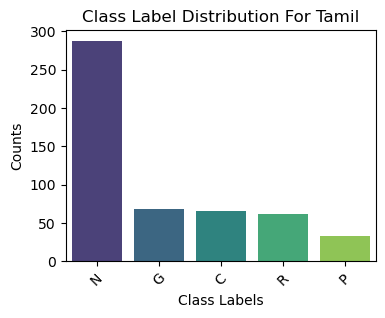

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each class label
label_counts = train_df['Class Label Short'].value_counts()

# Plot the class label counts
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Class Label Distribution For Tamil')
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate labels for better readability if necessary
plt.show()

In [5]:
train_df.head(2)

,Class Label Short,File Name,Transcript
0,C,H_TA_003_C_M_016_005,உருவத்தை வச்ச ஒருத்தன் கிண்டல் பண்றான் பாருங்க...
1,C,H_TA_003_C_M_016_004,காமெடி பண்ண சொன்னா ஒருத்தன உருவ கேலி பண்ணிட்டு...


In [11]:
audio_files = os.listdir(train_dir)
# Add a column to check if audio exists
train_df["Audio Exists"] = train_df["File Name"].apply(lambda x: f"{x}.wav" in audio_files) 
# Retain only rows where "Audio Exists" is True
train_df = train_df[train_df["Audio Exists"]]
# Optionally, reset the index if needed
train_df = train_df.reset_index(drop=True)

In [12]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-base")
texts = train_df['Transcript'].tolist()
test_text = test_df['Transcript'].tolist()
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=30)
test_input = tokenizer(test_text, padding=True, truncation=True, return_tensors="pt", max_length=30)

c:\Users\nimmi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
with torch.no_grad():
    text_features = model(**inputs).pooler_output 
    test_features = model(**test_input).pooler_output  # Shape: (batch_size, text_dim)

In [14]:
print(test_features.shape)  #(883, 768)

torch.Size([50, 768])


In [15]:
train_df['File Name'] = train_df['File Name'].apply(lambda x: f"{x}.wav" if not x.endswith(".wav") else x)
test_df['File Name'] = test_df['File Name'].apply(lambda x: f"{x}.wav" if not x.endswith(".wav") else x)

In [16]:
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract MFCCs
    return np.mean(mfccs.T, axis=0)  # Average over time axis

# Extract audio features for all audio files
audio_features = []
audio_test_features = []
for filename in train_df['File Name']:
    audio_path = f"{train_dir}/{filename}"
    audio_features.append(extract_audio_features(audio_path))

for filename in test_df['File Name']:
    audio_path = f"{test_dir}/{filename}"
    audio_test_features.append(extract_audio_features(audio_path))

audio_features = torch.tensor(audio_features, dtype=torch.float32) 
audio_test_features = torch.tensor(audio_test_features, dtype=torch.float32)# Shape: (num_samples, audio_dim)
print(audio_features.shape) 
print(audio_test_features.shape)  # Example: (num_samples, 13)


torch.Size([509, 13])
torch.Size([50, 13])


C:\Users\nimmi\AppData\Local\Temp\ipykernel_2904\2433454030.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  audio_features = torch.tensor(audio_features, dtype=torch.float32)


In [17]:
from sklearn.preprocessing import StandardScaler
import torch
# Convert to numpy array if needed
audio_features_np = audio_features.numpy() 
audio_test_features_np = audio_test_features.numpy()  # If using PyTorch tensors
scaler = StandardScaler()

# Fit and transform
audio_features_normalized = scaler.fit_transform(audio_features_np)
audio_features_normalized = torch.tensor(audio_features_normalized, dtype=torch.float32)
# Fit and transform
audio_test_features_normalized = scaler.fit_transform(audio_test_features_np)
audio_test_features_normalized = torch.tensor(audio_test_features_normalized, dtype=torch.float32)

# print(audio_features_normalized)

In [18]:
# Ensure both feature sets have the same batch size
combined_features = torch.cat((text_features, audio_features_normalized), dim=1)
combined_test_features = torch.cat((test_features, audio_test_features_normalized), dim=1)  # Shape: (num_samples, text_dim + audio_dim)
print(combined_features.shape) 
print(combined_test_features.shape)

torch.Size([509, 781])
torch.Size([50, 781])


In [19]:
# np.save('combined_features.npy', np.array(combined_features))
# np.save('combined_test_features', np.array(combined_test_features))

# combined_features = np.load('combined_features.npy')
# combined_test_features = np.load('combined_test_features.npy')

In [24]:
train_labels = train_df['Class Label Short'] 
classes_list = ["N", "G", "P", "R", "C"]          #  N==0(not hate)     hate(G, P, R, C)==1,2,3,4
train_labels = train_labels.apply(classes_list.index)
# test_labels = test_labels.apply(classes_list.index)

In [109]:
# Convert to torch tensors
X_train_tensor = torch.tensor(combined_features, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(combined_test_features, dtype=torch.float32)

y_train_tensor = torch.tensor(train_labels.to_numpy(), dtype=torch.long)
y_test_tensor = torch.tensor(test_labels.to_numpy(), dtype=torch.long)

# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\nimmi\AppData\Local\Temp\ipykernel_2904\761461807.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(combined_features, dtype=torch.float32)
C:\Users\nimmi\AppData\Local\Temp\ipykernel_2904\761461807.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(combined_test_features, dtype=torch.float32)


MODEL

In [110]:
class MultimodalClassifier(nn.Module):
    def __init__(self, text_dim, audio_dim, hidden_dim, output_dim):
        super(MultimodalClassifier, self).__init__()
        
        # Text subnetwork (deeper architecture)
        self.text_fc = nn.Sequential(
            nn.Linear(text_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1),  
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),  # Additional layer
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1)
        )
        
        # Audio subnetwork (deeper architecture)
        self.audio_fc = nn.Sequential(
            nn.Linear(audio_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),  # Additional layer
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1)
        )
        
        # Fusion and classification (deeper architecture)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),  # Additional layer
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)  # Use Sigmoid for binary classification
        )
    
    def forward(self, text_features, audio_features):
        # Process text and audio features separately
        text_out = self.text_fc(text_features)
        audio_out = self.audio_fc(audio_features)
        
        # Concatenate features and pass through fusion layers
        combined = torch.cat((text_out, audio_out), dim=1)
        output = self.fc(combined)
        return output


In [111]:
# Function to evaluate the model on validation set
def evaluate_model(model, val_loader, device):
    model.eval()  
    all_preds = []
    all_labels = []   
    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)            
            outputs = model(inputs[:, :text_features.shape[1]], inputs[:, text_features.shape[1]:])            
            _, preds = torch.max(outputs, 1)       
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy()) 
    return all_preds, all_labels

In [112]:
model = MultimodalClassifier(text_dim=text_features.shape[1], 
                             audio_dim=audio_features_normalized.shape[1], 
                             hidden_dim=256, 
                             output_dim=len(classes_list))
                        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Define loss function and optimizer 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [121]:
# Training loop
num_epochs = 80
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)     
        optimizer.zero_grad()  # Zero the gradients      
        # Forward pass
        outputs = model(inputs[:, :text_features.shape[1]], inputs[:, text_features.shape[1]:])      
        # Calculate loss and backpropagate
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()      
        running_loss += loss.item()      
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0) 
        correct += (predicted == labels).sum().item() 

In [122]:
y_pred, y_true = evaluate_model(model, test_loader, device)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro') 
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}") 
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}") 

Accuracy: 0.5600
Precision: 0.6969
Recall: 0.5600
F1 Score: 0.5567


              precision    recall  f1-score   support

           N       0.60      0.90      0.72        10
           G       0.64      0.70      0.67        10
           P       0.86      0.60      0.71        10
           R       0.80      0.80      0.80        10
           C       0.86      0.60      0.71        10

    accuracy                           0.72        50
   macro avg       0.75      0.72      0.72        50
weighted avg       0.75      0.72      0.72        50



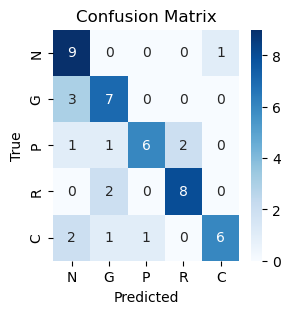

In [48]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=["N", "G", "P", "R", "C"])
print(report)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

SVM Accuracy: 0.52
              precision    recall  f1-score   support

           N       0.38      0.90      0.53        10
           G       0.75      0.30      0.43        10
           P       0.75      0.30      0.43        10
           R       0.75      0.60      0.67        10
           C       0.50      0.50      0.50        10

    accuracy                           0.52        50
   macro avg       0.62      0.52      0.51        50
weighted avg       0.62      0.52      0.51        50



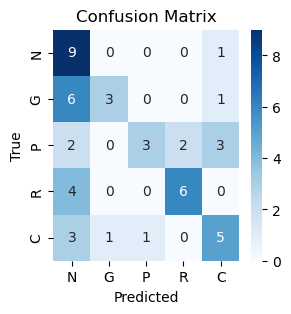

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


# test_labels = test_labels['labels']

# Scale features (important for KNN, SVM)
scaler = StandardScaler()
train_combined_features1 = scaler.fit_transform(combined_features)
test_combined_features1 = scaler.transform(combined_test_features)

# SVM
svm_model = SVC(kernel='rbf', C= 7, gamma= 'auto')
svm_model.fit(train_combined_features1, train_labels)
y_test_svm = svm_model.predict(test_combined_features1)
print("SVM Accuracy:", accuracy_score(test_labels, y_test_svm))
report = classification_report(test_labels, y_test_svm, target_names=['N', 'G', 'P', 'R', 'C'])
print(report)

cm = confusion_matrix(test_labels, y_test_svm)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

Random Forest Accuracy: 0.32
              precision    recall  f1-score   support

           N       0.23      1.00      0.38        10
           G       1.00      0.20      0.33        10
           P       0.00      0.00      0.00        10
           R       1.00      0.10      0.18        10
           C       0.75      0.30      0.43        10

    accuracy                           0.32        50
   macro avg       0.60      0.32      0.26        50
weighted avg       0.60      0.32      0.26        50



c:\Users\nimmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nimmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nimmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


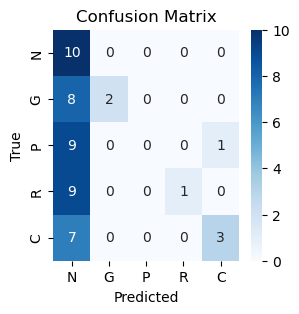

In [139]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
rf_model = RandomForestClassifier(n_estimators= 250, random_state=100, min_samples_split = 2, min_samples_leaf = 1, criterion = 'gini', max_features = 'sqrt')
rf_model.fit(combined_features, train_labels)
y_pred_rf = rf_model.predict(combined_test_features)
print("Random Forest Accuracy:", accuracy_score(test_labels, y_pred_rf))  
report = classification_report(test_labels, y_pred_rf, target_names=['N', 'G', 'P', 'R', 'C'])
print(report)

cm = confusion_matrix(test_labels, y_pred_rf)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           N       0.29      0.80      0.42        10
           G       0.67      0.60      0.63        10
           P       1.00      0.10      0.18        10
           R       0.50      0.40      0.44        10
           C       0.75      0.30      0.43        10

    accuracy                           0.44        50
   macro avg       0.64      0.44      0.42        50
weighted avg       0.64      0.44      0.42        50



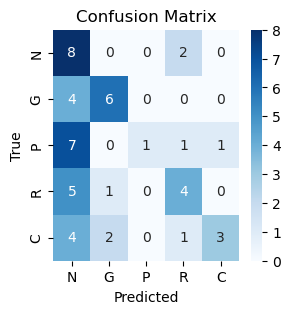

In [147]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=3, weights = 'uniform', algorithm = 'kd_tree', leaf_size = 2, p=2, metric='minkowski')
knn_model.fit(combined_features, train_labels)
y_pred_knn = knn_model.predict(combined_test_features)
report = classification_report(test_labels, y_pred_knn, target_names=['N', 'G', 'P', 'R', 'C'])
print(report) 

cm = confusion_matrix(test_labels, y_pred_knn)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           N       0.14      0.10      0.12        10
           G       1.00      0.20      0.33        10
           P       0.50      0.50      0.50        10
           R       0.50      0.70      0.58        10
           C       0.35      0.60      0.44        10

    accuracy                           0.42        50
   macro avg       0.50      0.42      0.40        50
weighted avg       0.50      0.42      0.40        50



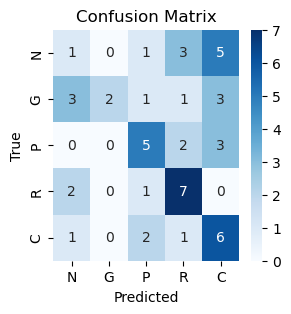

In [35]:
# Naive Bayes (not ideal for embeddings)
nb_model = GaussianNB()
nb_model.fit(combined_features, train_labels)
y_pred_nb = nb_model.predict(combined_test_features)
report = classification_report(test_labels, y_pred_nb, target_names=['N', 'G', 'P', 'R', 'C'])
print(report)

cm = confusion_matrix(test_labels, y_pred_nb)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           N       0.23      0.90      0.36        10
           G       0.00      0.00      0.00        10
           P       0.67      0.20      0.31        10
           R       0.60      0.30      0.40        10
           C       0.00      0.00      0.00        10

    accuracy                           0.28        50
   macro avg       0.30      0.28      0.21        50
weighted avg       0.30      0.28      0.21        50



c:\Users\nimmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nimmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nimmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


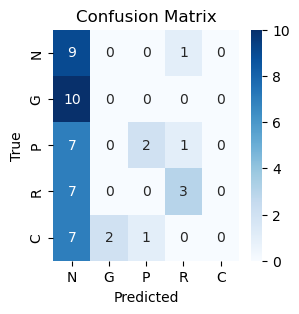

In [149]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=600)

# Train the model
lr_model.fit(combined_features, train_labels)

# Predict using the test data
y_pred_lr = lr_model.predict(combined_test_features)

# Generate the classification report
report = classification_report(test_labels, y_pred_lr, target_names=['N', 'G', 'P', 'R', 'C'])
print(report)

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_lr)

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'G', 'P', 'R', 'C'], yticklabels=['N', 'G', 'P', 'R', 'C'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 